## Dataset preparation from online

In [1]:
from google_images_download import google_images_download
import os
original_path = os.getcwd()
data_path = os.path.join(original_path,'downloads')

In [2]:
response = google_images_download.googleimagesdownload()
search_queries = ['happy dogs','smiling dogs','sad dogs','frown dogs']

In [3]:
def downloadimages(query):
    arguments = dict(keywords=query,
                    limit=20,#1000,
                    format='jpg',
                    chromedriver='C:\\Users\\sungsooc\\Documents\\chromedriver_win32\\chromedriver.exe', 
                    silent_mode=True)
    try: 
        response.download(arguments)     
    except FileNotFoundError:  
        arguments = dict(keywords=query,
                    limit=20,
                    format='jpg',
                    print_urls=True)                       
        try:  
            response.download(arguments)  
        except: 
            pass

In [9]:
download_msg = []
for query in search_queries: 
    downloadimages(query)
    msg = 'Downloaded {} {} images!'.format(len(os.listdir(os.path.join(data_path,query))),query)
    download_msg.append(msg)
for msg in download_msg:
    print(msg)

Downloaded 20 happy dogs images!
Downloaded 20 smiling dogs images!
Downloaded 20 sad dogs images!
Downloaded 20 frown dogs images!


#### NOTE: at this stage, manually go over the downloaded files to get rid of "bad" images; this does not necessarily have to be thorough. 

### Processing into two categories

In [10]:
import shutil
data_folders = os.listdir(data_path)

source_happy = os.path.join(data_path,'smiling dogs')
dest_happy = os.path.join(data_path,'happy dogs')
source_sad = os.path.join(data_path,'frown dogs')
dest_sad = os.path.join(data_path,'sad dogs')

files_happy = os.listdir(source_happy)
files_sad = os.listdir(source_sad)
for f in files_happy:
    if not os.path.exists(os.path.join(dest_happy,f)):
        shutil.move(os.path.join(source_happy,f), dest_happy)   
for f in files_sad:
    if not os.path.exists(os.path.join(dest_sad,f)):
        shutil.move(os.path.join(source_sad,f), dest_sad)
        
shutil.rmtree(os.path.join(data_path,'smiling dogs'))
shutil.rmtree(os.path.join(data_path,'frown dogs'))

### File renaming

In [14]:
data_folders = os.listdir(data_path)
for folder in data_folders:
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    current_list = os.listdir(os.getcwd())
    for i in range(len(os.listdir(working_dir))):
        original_name = current_list[i]
        new_name = "".join(folder.split()) + '_{:04d}'.format(i+1) + os.path.splitext(original_name)[-1]
        if not os.path.exists(new_name):
            os.rename(original_name,new_name)
os.chdir(original_path)

## display

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

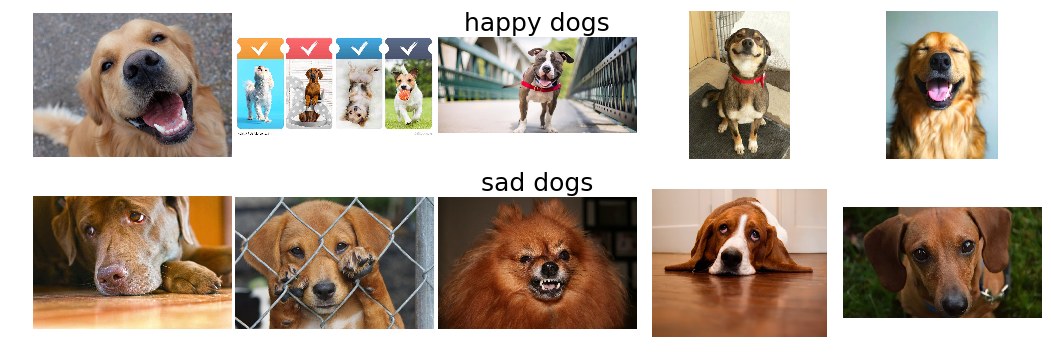

In [16]:
np.random.seed(seed=0)
n_samples = 5
fig, row = plt.subplots(2, n_samples, figsize = (4*n_samples, 3*2))

for col,folder in zip(row,data_folders):
    col[int(np.floor(n_samples/2))].set_title(folder,fontsize=25)
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    for col_ax,img in zip(col,np.random.choice(os.listdir(os.getcwd()),n_samples,replace=False)):
        rand_img = cv2.imread(img)
        rand_img = cv2.cvtColor(rand_img,cv2.COLOR_BGR2RGB)
        col_ax.imshow(rand_img)
        col_ax.axis('off')
plt.subplots_adjust(left=0.2, wspace=0.02)
os.chdir(original_path)

## Load and pre-processing

In [17]:
img_rows = 128
img_cols = 128
img_list = []
label_list = []
labels = dict([('sad dogs',0),('happy dogs',1)])
for folder in data_folders:
    working_dir = os.path.join(data_path,folder)
    os.chdir(working_dir)
    current_list = os.listdir(os.getcwd())
    for img in current_list:
#         img_in = cv2.imread(img,0) # process in gray-scale as color is not important for the goal
        img_in = cv2.imread(img)    
        img_in = cv2.cvtColor(img_in,cv2.COLOR_BGR2RGB)    
        img_in = cv2.resize(img_in,(img_rows,img_cols))
        img_list.append(img_in)
        label_list.append(labels[folder])
os.chdir(original_path)

### normalization

In [18]:
img_data = np.array(img_list).astype('float32')
img_label = np.array(label_list)
img_data /= 255
# img_data = np.expand_dims(img_data,axis=3)

In [19]:
print(img_data.shape) #(m,row,col,channel)
print(img_label.shape)

(79, 128, 128, 3)
(79,)


## Splitting

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_shuffled, y_shuffled = shuffle(img_data,img_label,random_state=0)

X_train,X_valid_test,y_train,y_valid_test = train_test_split(X_shuffled,y_shuffled,test_size=0.1,random_state=0,stratify=y_shuffled)
X_valid,X_test,y_valid,y_test = train_test_split(X_valid_test,y_valid_test,test_size=0.5,random_state=0,stratify=y_valid_test)
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_valid shape: {}'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (71, 128, 128, 3)
y_train shape: (71,)
X_valid shape: (4, 128, 128, 3)
y_valid shape: (4,)
X_test shape: (4, 128, 128, 3)
y_test shape: (4,)


## Model building

In [32]:
from keras.models import Sequential
from keras.layers import Dense,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dropout
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam

In [22]:
%load_ext autoreload
%autoreload 2
import helper_module as hm

In [27]:
epochs = 30#350
batch_size = 32
X_input_shape = img_data[0].shape
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=6,verbose=1,factor=0.7,min_lr=0.00001)

### Model #1: arbitrary CNN - initial trial
As an initial model, a simple CNN with 2 conv layers and 1 fc layer is built.

In [28]:
model_name = 'Model_1'
optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=10**-8, amsgrad=False)
model_1 = Sequential([
    Conv2D(32,(3,3),padding='same',input_shape=X_input_shape),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    Conv2D(64,(3,3),padding='same'),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.5),

    Flatten(),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')])
model_1.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
best_model_path = os.path.join('best_models','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5')
print(model_name)
hm.print_train_num_param(model_1)

Trainable params: 4,214,017


In [29]:
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_1 = model_1.fit(X_train,y_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 verbose=0,
                 validation_data=(X_valid,y_valid),
                 callbacks=[save_best_model,learning_rate_reduction])


Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00024500001163687554.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00017150000203400848.


4/4 [==============================] - 0s 997us/step
Valid: accuracy = 0.500000  ;  loss = 0.451757
Test: accuracy = 0.750000  ;  loss = 0.634569


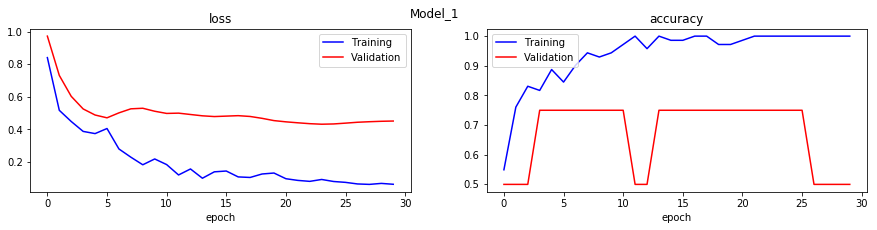

In [30]:
hm.print_valid_test_score(model_1,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_1,model_name) 

### Model #2: CNN with a GAP layer - to reduce the degree of overfitting
The first model showed extremely high variance problem. One possible approach to reduce overfitting is to decrease the number of the hyperparameters. By replacing a Flatten layer with a GAP (global average pooling) layer, the number of hyperparameters can be greatly reduced. This may cause underfitting issue, therefore the bottom conv layers need to be adjusted accordingly.

In [38]:
model_name = 'Model_2'
optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=10**-8, amsgrad=False)
model_2 = Sequential([
    Conv2D(64,(3,3),padding='same',input_shape=X_input_shape),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    Conv2D(128,(3,3),padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    Conv2D(256,(3,3),padding='same'),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    GlobalAveragePooling2D(),
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')])
model_2.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
best_model_path = os.path.join('best_models','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5')
print(model_name)
hm.print_train_num_param(model_2)

Trainable params: 420,609


In [34]:
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_2 = model_2.fit(X_train,y_train,
                 epochs=epochs,
                 batch_size=batch_size,
                 verbose=0,
                 validation_data=(X_valid,y_valid),
                 callbacks=[save_best_model,learning_rate_reduction])


Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.00024500001163687554.


4/4 [==============================] - 0s 1ms/step
Valid: accuracy = 0.250000  ;  loss = 0.719181
Test: accuracy = 0.750000  ;  loss = 0.590012


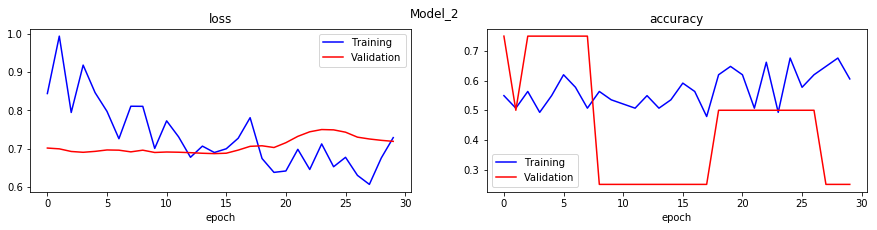

In [35]:
hm.print_valid_test_score(model_2,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_2,model_name) 

### Model #3: complex model with Data augmentation
aa

In [39]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,)
                             #rotation_range=45,)
datagen.fit(X_train)

In [83]:
model_name = 'Model_3'
optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=10**-8, amsgrad=False)
model_3 = Sequential([
    Conv2D(64,(3,3),padding='same',input_shape=X_input_shape),
    Activation('relu'),
    Conv2D(64,(3,3),padding='same'),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),padding='same'),
    Activation('relu'),
    Conv2D(128,(3,3),padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    Conv2D(256,(3,3),padding='same'),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.5),

    GlobalAveragePooling2D(),
    Dense(128),
    Activation('relu'),
    Dense(128),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid')])

model_3.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
best_model_path = os.path.join('best_models','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5')
print(model_name)
hm.print_train_num_param(model_3)

Model_3
Trainable params: 605,121


In [41]:
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_3 = model_3.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)/batch_size,
                                           epochs=epochs,
                                           verbose=0,
                                           validation_data=(X_valid,y_valid),
                                           callbacks=[save_best_model,learning_rate_reduction])


Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00024500001163687554.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.00017150000203400848.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.00012004999734926967.


4/4 [==============================] - 0s 1ms/step
Valid: accuracy = 0.500000  ;  loss = 1.433904
Test: accuracy = 0.500000  ;  loss = 1.408759


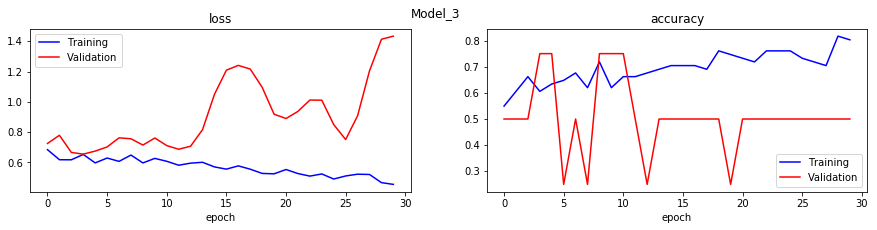

In [42]:
hm.print_valid_test_score(model_3,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_3,model_name) 

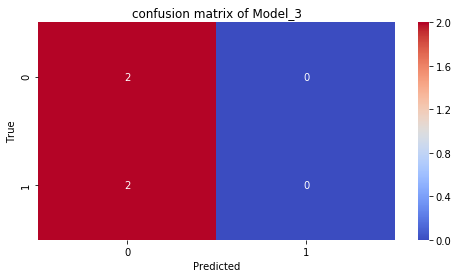

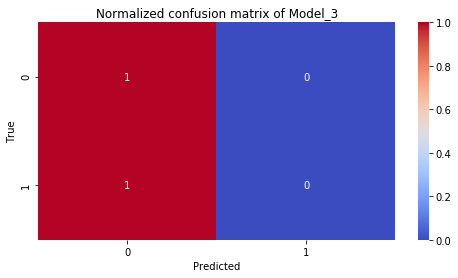

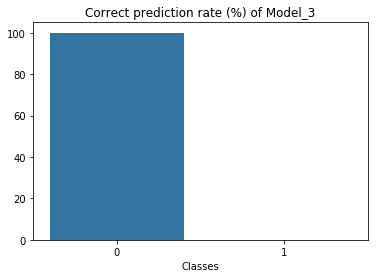

In [43]:
y_pred = model_3.predict_classes(X_test)
hm.confusion_matrix_plot(y_test,y_pred,model_name)

## add transfer learning

In [94]:
from keras.applications.vgg16 import VGG16
model_name = 'Model_4'
optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=10**-8, amsgrad=False)

model_4_bottom = VGG16(include_top=False, weights='imagenet',input_shape=X_input_shape)
model_4 = Sequential([
    model_4_bottom,
    Flatten(),
    Dense(128),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid')
])
print(model_name+' before freezing')
hm.print_train_num_param(model_4)

Model_4 before freezing
Trainable params: 15,763,521


In [95]:
model_4_bottom.trainable = False
print(model_name+' after freezing')
hm.print_train_num_param(model_4)

Model_4 after freezing
Trainable params: 1,048,833


In [97]:
model_4.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
best_model_path = os.path.join('best_models','best-wiehgts-'+model_name+'-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5')
save_best_model = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
hist_4 = model_4.fit_generator(datagen.flow(X_train,y_train,batch_size=batch_size),
                                           steps_per_epoch = len(X_train)/batch_size,
                                           epochs=epochs,
                                           verbose=0,
                                           validation_data=(X_valid,y_valid),
                                           callbacks=[save_best_model,learning_rate_reduction])


Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00035000001662410796.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.00024500001163687554.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.00017150000203400848.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.00012004999734926967.


4/4 [==============================] - 0s 4ms/step
Valid: accuracy = 0.750000  ;  loss = 0.836509
Test: accuracy = 0.750000  ;  loss = 0.322302


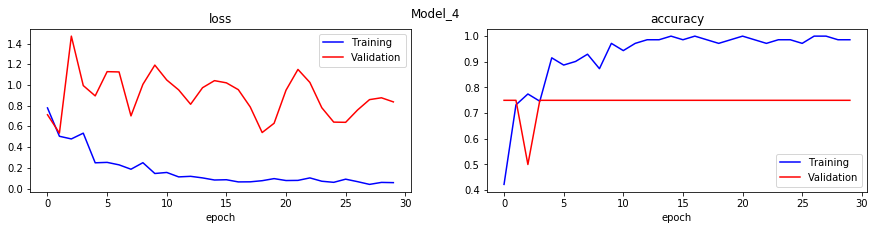

In [98]:
hm.print_valid_test_score(model_4,X_valid,y_valid,X_test,y_test)
hm.training_plot(hist_4,model_name) 

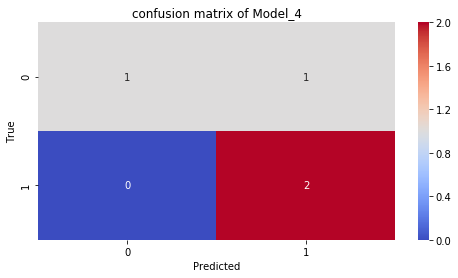

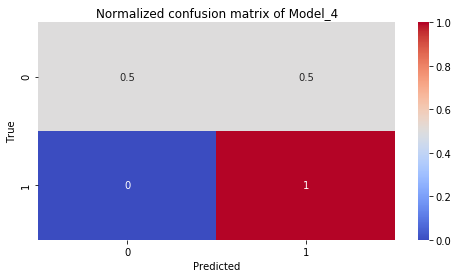

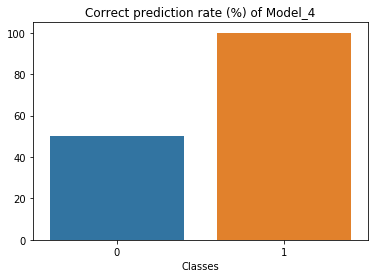

In [99]:
y_pred = model_4.predict_classes(X_test)
hm.confusion_matrix_plot(y_test,y_pred,model_name)

## Testing new image of Lucky!

In [102]:
from keras.models import load_model

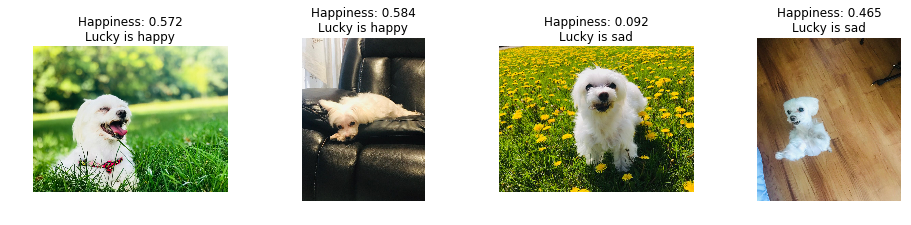

In [104]:
chosen_model = load_model(os.path.join('best_models','best-wiehgts-Model_4-029-0.411-0.750.hdf5'))
fig, axes = plt.subplots(1, 4, figsize = (4*4, 3*1))
for ax,img_num in zip(axes,range(1,5)):
    img = cv2.imread('Lucky_'+str(img_num)+'.jpg')
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    
    img = cv2.resize(img,(img_rows,img_cols)).astype('float32')
    img /= 255
    img = np.expand_dims(img,axis=0)
    ax.axis('off')
    predict_rate = chosen_model.predict(img)[0][0]
    predict_class = chosen_model.predict_classes(img)[0][0]
    ax.set_title('Happiness: {:.3f}\nLucky is {}'.format(predict_rate,
                                                list(labels.keys())[list(labels.values()).index(predict_class)].split()[0]))


## To do..
* show mislabeled examples
* make the notebook using image generator
* articles about using flow and flow_from_directory